# Import Library

In [1]:
!pip install keras_tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 2.9 MB/s eta 0:00:00


In [2]:
import os
import shutil
import holidays
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from google.colab import drive

# Impor library statistik
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Preprocessing & Metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error

# Deep Learning (TensorFlow)
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Tuning
import keras_tuner as kt

print("Library berhasil diimpor.")

Library berhasil diimpor.


# Data Preparation

## Load Data

In [3]:
drive.mount('/content/drive')

# Tentukan path folder data Anda
base_path = '/content/drive/MyDrive/Magang Prima PTKI/data_dummy'

try:
    transactions_df = pd.read_csv(os.path.join(base_path, 'transactions.csv'))
    transaction_details_df = pd.read_csv(os.path.join(base_path, 'transaction_details.csv'))
    products_df = pd.read_csv(os.path.join(base_path, 'products.csv'))
    stores_df = pd.read_csv(os.path.join(base_path, 'stores.csv'))
    print("Semua file CSV berhasil dimuat.")
except FileNotFoundError as e:
    print(f"Error: Pastikan file CSV ada di folder {base_path}")

Mounted at /content/drive
Semua file CSV berhasil dimuat.


## Merging Data

In [4]:
# 1. Merging
df_merged = pd.merge(transactions_df, transaction_details_df, left_on='id', right_on='transactionId')
df_merged = pd.merge(df_merged, products_df[['id', 'productCategoryId']], left_on='productId', right_on='id', suffixes=('', '_prod'))
df_merged = pd.merge(df_merged, stores_df[['id', 'storeTypeId']], left_on='storeId', right_on='id', suffixes=('', '_store'))

In [5]:
# 2. Filter Spesifik Store ID 10
TARGET_STORE_ID = 10
df_fashion = df_merged[df_merged['storeId'] == TARGET_STORE_ID].copy()
df_fashion['transactionDate'] = pd.to_datetime(df_fashion['transactionDate'])

## Data Cleaning

In [6]:
# 3. Agregasi Harian
time_series_fashion = df_fashion.groupby(df_fashion['transactionDate'].dt.date)['subtotal'].sum().reset_index()
time_series_fashion.columns = ['date', 'revenue']
time_series_fashion['date'] = pd.to_datetime(time_series_fashion['date'])
time_series_fashion.set_index('date', inplace=True)

In [7]:
# 4. Reindex (Isi hari kosong dengan 0)
all_days = pd.date_range(start=time_series_fashion.index.min(), end=time_series_fashion.index.max(), freq='D')
time_series_fashion = time_series_fashion.reindex(all_days, fill_value=0)

In [8]:
# 5. Cleaning Outliers (Clipping agar pola musiman/weekend tidak hilang)
Q1 = time_series_fashion['revenue'].quantile(0.25)
Q3 = time_series_fashion['revenue'].quantile(0.75)
IQR = Q3 - Q1

time_series_fashion['revenue_clean'] = time_series_fashion['revenue'].clip(lower=Q1 - 1.5*IQR, upper=Q3 + 1.5*IQR)

print(f"Data Fashion (Store {TARGET_STORE_ID}) siap proses.")

Data Fashion (Store 10) siap proses.


# Exploratory Data Analysis (EDA)

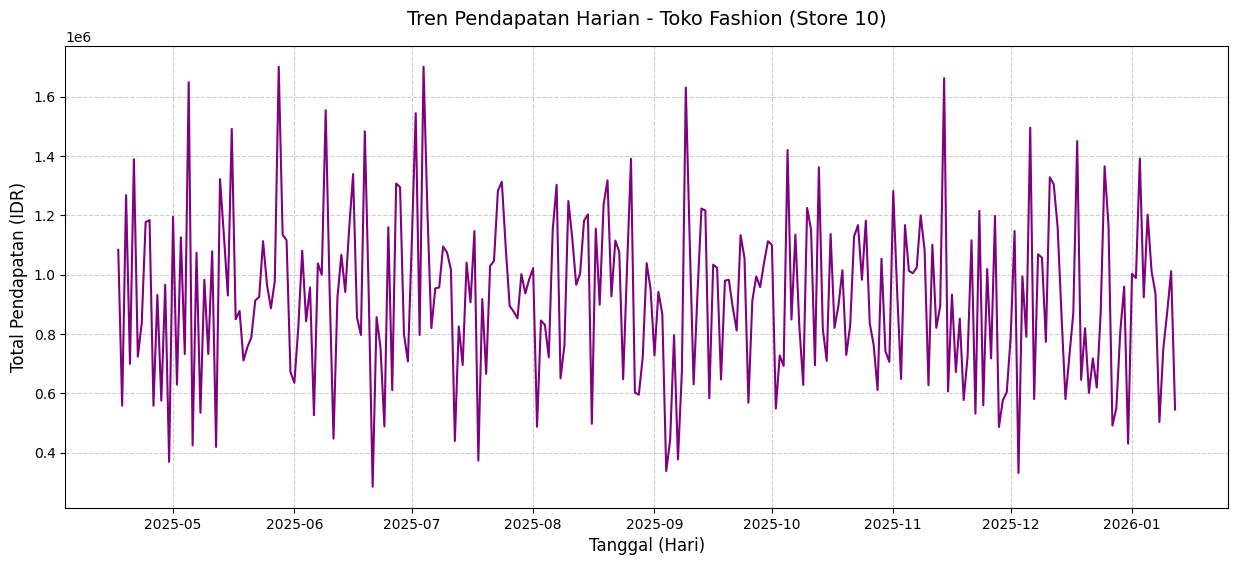

In [9]:
# 1. Visualisasi Tren Pendapatan Harian
plt.figure(figsize=(15, 6))
plt.plot(time_series_fashion.index, time_series_fashion['revenue_clean'], color='purple', linewidth=1.5)
plt.title('Tren Pendapatan Harian - Toko Fashion (Store 10)', fontsize=14, pad=15)
plt.xlabel('Tanggal (Hari)', fontsize=12)
plt.ylabel('Total Pendapatan (IDR)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

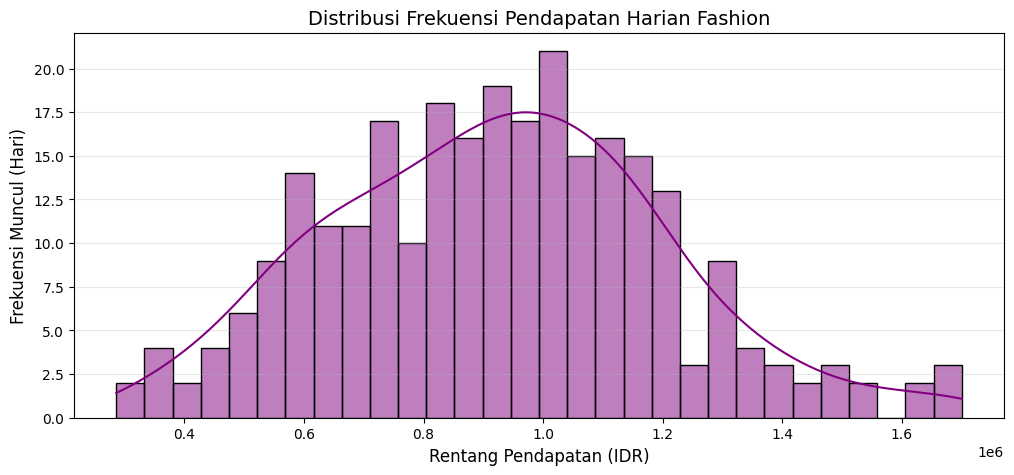

In [10]:
# 2. Visualisasi Distribusi Pendapatan
plt.figure(figsize=(12, 5))
sns.histplot(time_series_fashion['revenue_clean'], kde=True, color='purple', bins=30)
plt.title('Distribusi Frekuensi Pendapatan Harian Fashion', fontsize=14)
plt.xlabel('Rentang Pendapatan (IDR)', fontsize=12)
plt.ylabel('Frekuensi Muncul (Hari)', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.show()

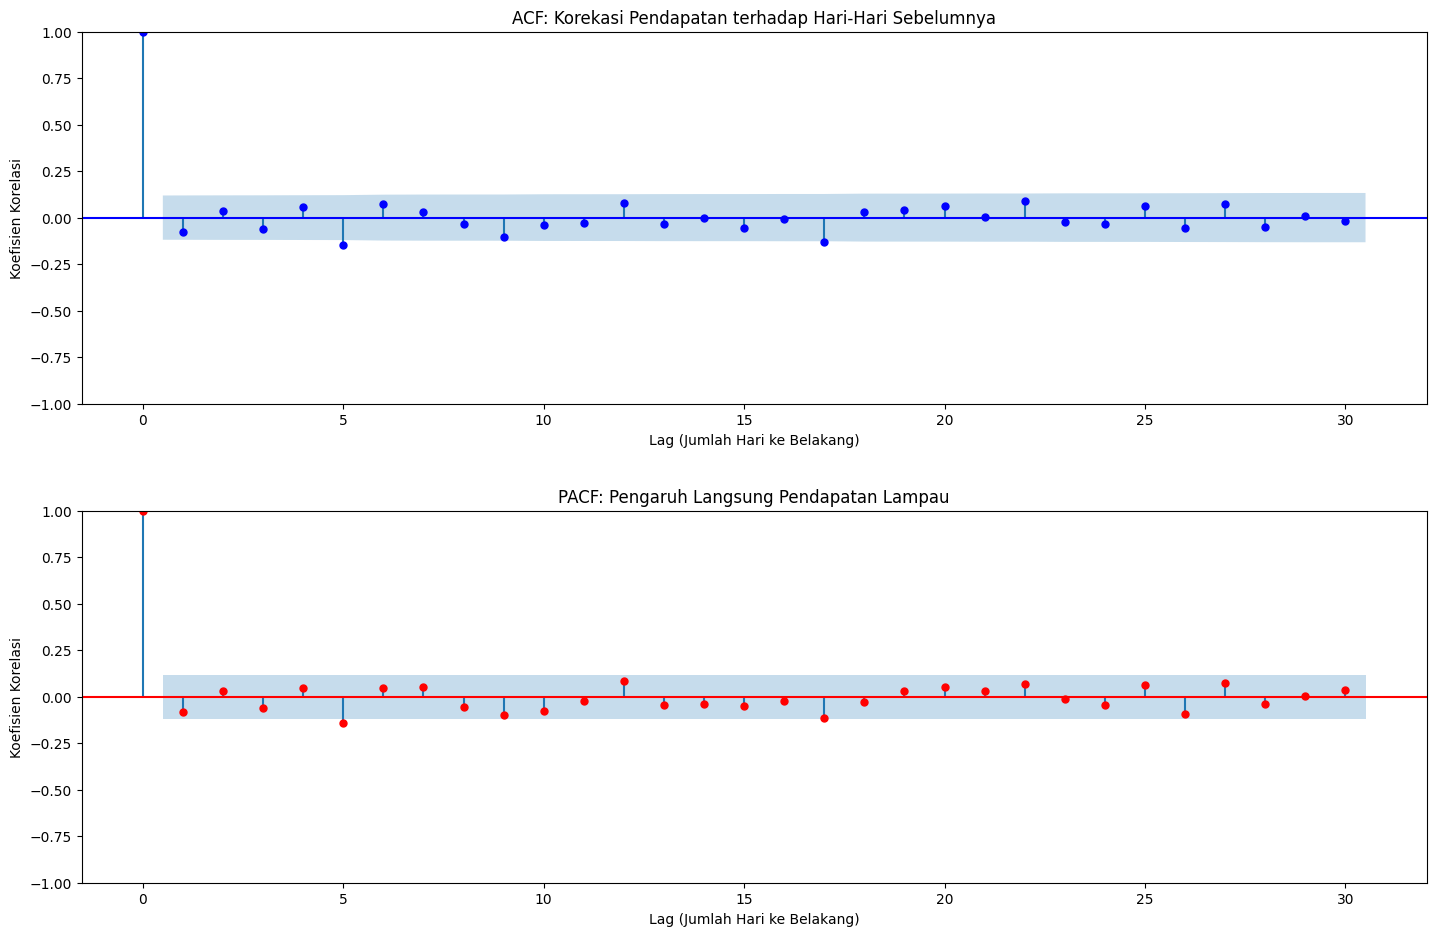

In [11]:
# 3. Analisis Autokorelasi (Pola Musiman)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# ACF
plot_acf(time_series_fashion['revenue_clean'], lags=30, ax=ax1, color='blue')
ax1.set_title('ACF: Korekasi Pendapatan terhadap Hari-Hari Sebelumnya', fontsize=12)
ax1.set_xlabel('Lag (Jumlah Hari ke Belakang)', fontsize=10)
ax1.set_ylabel('Koefisien Korelasi', fontsize=10)

# PACF
plot_pacf(time_series_fashion['revenue_clean'], lags=30, ax=ax2, color='red')
ax2.set_title('PACF: Pengaruh Langsung Pendapatan Lampau', fontsize=12)
ax2.set_xlabel('Lag (Jumlah Hari ke Belakang)', fontsize=10)
ax2.set_ylabel('Koefisien Korelasi', fontsize=10)

plt.tight_layout(pad=3.0)
plt.show()

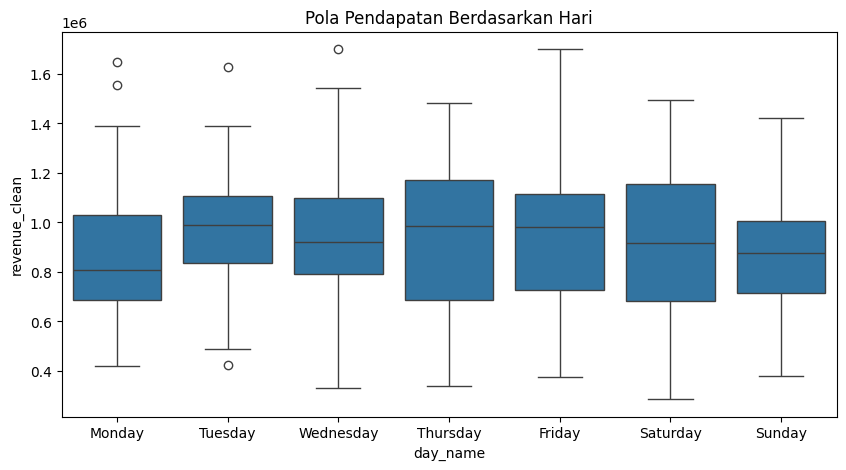

In [12]:
# EDA: Analisis Seasonal (Hari dalam seminggu)
# Kita ingin melihat apakah di hari Sabtu/Minggu benar-benar ada lonjakan signifikan
time_series_fashion['day_name'] = time_series_fashion.index.day_name()
order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
plt.figure(figsize=(10, 5))
sns.boxplot(x='day_name', y='revenue_clean', data=time_series_fashion, order=order)
plt.title('Pola Pendapatan Berdasarkan Hari')
plt.show()

In [13]:
# 4. Ringkasan Statistik dengan Format Rupiah
stats = time_series_fashion['revenue_clean'].describe()
print("="*45)
print("   RINGKASAN STATISTIK PENDAPATAN FASHION")
print("="*45)
print(f"Jumlah Data (Hari)  : {stats['count']:,.0f}")
print(f"Rata-rata Harian    : Rp {stats['mean']:,.2f}")
print(f"Standar Deviasi     : Rp {stats['std']:,.2f}")
print(f"Pendapatan Minimum  : Rp {stats['min']:,.2f}")
print(f"Median (P50)        : Rp {stats['50%']:,.2f}")
print(f"Pendapatan Maksimum : Rp {stats['max']:,.2f}")
print("="*45)

   RINGKASAN STATISTIK PENDAPATAN FASHION
Jumlah Data (Hari)  : 271
Rata-rata Harian    : Rp 924,800.74
Standar Deviasi     : Rp 278,065.58
Pendapatan Minimum  : Rp 286,000.00
Median (P50)        : Rp 932,000.00
Pendapatan Maksimum : Rp 1,700,500.00


# Preprocessing Data

## Feature Engineering

(Menambah Konteks Waktu)

In [14]:
# A. Fitur Hari Libur Indonesia
id_holidays = holidays.Indonesia(years=[2025, 2026])
time_series_fashion['is_holiday'] = time_series_fashion.index.strftime('%Y-%m-%d').isin(id_holidays).astype(int)

# B. Fitur Payday (Siklus gajian Balikpapan: tgl 25 - 5)
time_series_fashion['is_payday'] = time_series_fashion.index.day.map(lambda x: 1 if x >= 25 or x <= 5 else 0)

# C. Fitur Weekend
time_series_fashion['is_weekend'] = time_series_fashion.index.weekday.map(lambda x: 1 if x >= 5 else 0)

In [15]:
# D. Fitur Lag 1-7 (Kunci utama menurunkan MAPE)
# Memberikan model informasi pendapatan 1-7 hari ke belakang secara eksplisit
for i in range(1, 8):
    time_series_fashion[f'lag_{i}'] = time_series_fashion['revenue_clean'].shift(i)

In [16]:
# E. Fitur Tren (Rolling Average 7 hari)
time_series_fashion['rolling_avg_7d'] = time_series_fashion['revenue_clean'].rolling(window=7).mean()

In [17]:
# Update Feature Engineering (Menambah Day of Month)
time_series_fashion['day_of_month'] = time_series_fashion.index.day

In [18]:
# F. Hapus baris NaN yang muncul akibat proses shifting lag dan rolling average
time_series_fashion.dropna(inplace=True)

In [19]:
# Definisikan Input (X) dan Target (y)
# Kita menggunakan 11 fitur: Lag (1-7), is_holiday, is_payday, is_weekend, dan rolling_avg_7d
features = [f'lag_{i}' for i in range(1, 8)] + ['is_holiday', 'is_payday', 'is_weekend', 'rolling_avg_7d', 'day_of_month']
X_raw = time_series_fashion[features]
y_raw = time_series_fashion['revenue_clean']

print(f"Feature Engineering Selesai. Total Fitur: {len(features)}")

Feature Engineering Selesai. Total Fitur: 12


## Scaling

In [20]:
# Scaling (Normalisasi)
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

In [21]:
X_scaled = scaler_X.fit_transform(X_raw)
y_scaled = scaler_y.fit_transform(y_raw.values.reshape(-1, 1))

In [22]:
# Reshaping untuk format 3D (Input Model Deep Learning)
# Format: (Jumlah Sampel, Time Steps=1, Jumlah Fitur=11)
X_final = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))
y_final = y_scaled

## Splitting Data (Train & Test)

In [23]:
# Data Splitting (80% Train, 20% Test)
train_size = int(len(X_final) * 0.8)
X_train, X_test = X_final[:train_size], X_final[train_size:]
y_train, y_test = y_final[:train_size], y_final[train_size:]

In [24]:
print("-" * 30)
print(f"Shape X_train: {X_train.shape}") # Harus (N, 1, 11)
print(f"Shape y_train: {y_train.shape}")
print("-" * 30)
print("Preprocessing selesai. Siap lanjut ke Modeling.")

------------------------------
Shape X_train: (211, 1, 12)
Shape y_train: (211, 1)
------------------------------
Preprocessing selesai. Siap lanjut ke Modeling.


# Modeling

In [25]:
# Sesuaikan nama folder dengan kategori toko
tuner_path = 'tuner_dir/fashion_store_10_tuning'

if os.path.exists(tuner_path):
    shutil.rmtree(tuner_path)
    print(f"Folder {tuner_path} berhasil dihapus. Memulai sesi training baru untuk Fashion.")
else:
    print(f"ℹFolder {tuner_path} tidak ditemukan. Memulai dari awal.")

ℹFolder tuner_dir/fashion_store_10_tuning tidak ditemukan. Memulai dari awal.


In [26]:
def model_builder(hp):
    model = Sequential()

    # 1. CNN Layer: Ekstraksi fitur antar kolom dalam 1 time step
    model.add(Conv1D(
        filters=hp.Int("conv_filters", min_value=32, max_value=128, step=16),
        kernel_size=1,
        activation='relu',
        padding='same',
        input_shape=(X_train.shape[1], X_train.shape[2])
    ))
    model.add(MaxPooling1D(pool_size=1))

    # 2. Bi-LSTM Layer: Menangkap pola non-linear dari fitur lag
    model.add(Bidirectional(
        LSTM(
            units=hp.Int("bilstm_units", min_value=64, max_value=256, step=32),
            return_sequences=True
        )
    ))
    model.add(Dropout(rate=hp.Float("dropout_1", min_value=0.1, max_value=0.4, step=0.1)))

    # 3. LSTM Layer Kedua: Pendalaman abstraksi data
    model.add(LSTM(
        units=hp.Int("lstm_units", min_value=32, max_value=128, step=32),
        return_sequences=False
    ))

    # 4. Dense Layers (Fully Connected)
    model.add(Dense(units=hp.Int("dense_units", min_value=32, max_value=128, step=32), activation='relu'))
    model.add(Dense(1))

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mean_squared_error',
        metrics=['mae']
    )

    return model

# Reset Tuner untuk Fashion (Agar tidak tercampur hasil FnB)
import shutil
tuner_dir = 'tuner_dir/fashion_store_10'
if os.path.exists(tuner_dir):
    shutil.rmtree(tuner_dir)

tuner = kt.RandomSearch(
    model_builder,
    objective='val_loss',
    max_trials=10,
    directory='tuner_dir',
    project_name='fashion_store_10',
    overwrite=True
)

early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

print("Memulai Hyperparameter Tuning untuk Toko Fashion...")
tuner.search(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[early_stop])

# Ambil Model Terbaik
best_model = tuner.get_best_models(num_models=1)[0]
print("\nTuning Selesai. Arsitektur model terbaik dipilih.")
best_model.summary()

Trial 10 Complete [00h 00m 24s]
val_loss: 0.004537709057331085

Best val_loss So Far: 0.0029204280581325293
Total elapsed time: 00h 03m 10s

Tuning Selesai. Arsitektur model terbaik dipilih.


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 1, 112)         │         1,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 1, 112)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 1, 512)         │       755,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 512)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        69,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 96)             │         3,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            97 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 830,193 (3.17 MB)

 Trainable params: 830,193 (3.17 MB)

 Non-trainable params: 0 (0.00 B)

# Evaluation & Visualization

In [27]:
# 1. Pelatihan Akhir Model Terbaik
print("Melatih model terbaik...")
history = best_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=16,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

Melatih model terbaik...
Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - loss: 0.0084 - mae: 0.0724 - val_loss: 0.0037 - val_mae: 0.0464
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0079 - mae: 0.0729 - val_loss: 0.0047 - val_mae: 0.0564
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0050 - mae: 0.0580 - val_loss: 0.0033 - val_mae: 0.0466
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0037 - mae: 0.0476 - val_loss: 0.0035 - val_mae: 0.0473
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0041 - mae: 0.0501 - val_loss: 0.0054 - val_mae: 0.0582
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0033 - mae: 0.0463 - val_loss: 0.0032 - val_mae: 0.0434
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0025 - mae: 0.0399 - val_loss: 0.0024 - val_mae: 0.0391
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0027 - mae: 0.0414 - val_loss: 0.0047 - val_mae: 0.0575
Epoch 9/100
11/11 ━━━━━━━━━━━━━

In [28]:
# 2. Melakukan Prediksi pada Data Uji
y_pred_scaled = best_model.predict(X_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 504ms/step


In [29]:
# 3. Inverse Scale (Kembalikan ke nilai Rupiah asli)
y_pred = scaler_y.inverse_transform(y_pred_scaled).ravel()
y_actual = scaler_y.inverse_transform(y_test).ravel()

In [30]:
# 4. Hitung Metrik Evaluasi
mae = mean_absolute_error(y_actual, y_pred)
mape = mean_absolute_percentage_error(y_actual, y_pred) * 100
r2 = r2_score(y_actual, y_pred)

In [31]:
print("="*40)
print("   HASIL EVALUASI MODEL FASHION")
print("="*40)
print(f"Mean Absolute Error (MAE)  : Rp {mae:,.2f}")
print(f"Mean Absolute Percentage Error (MAPE) : {mape:.2f}%")
print(f"R2-Score (Goodness of Fit) : {r2:.4f}")
print("="*40)

   HASIL EVALUASI MODEL FASHION
Mean Absolute Error (MAE)  : Rp 64,340.41
Mean Absolute Percentage Error (MAPE) : 8.27%
R2-Score (Goodness of Fit) : 0.9268


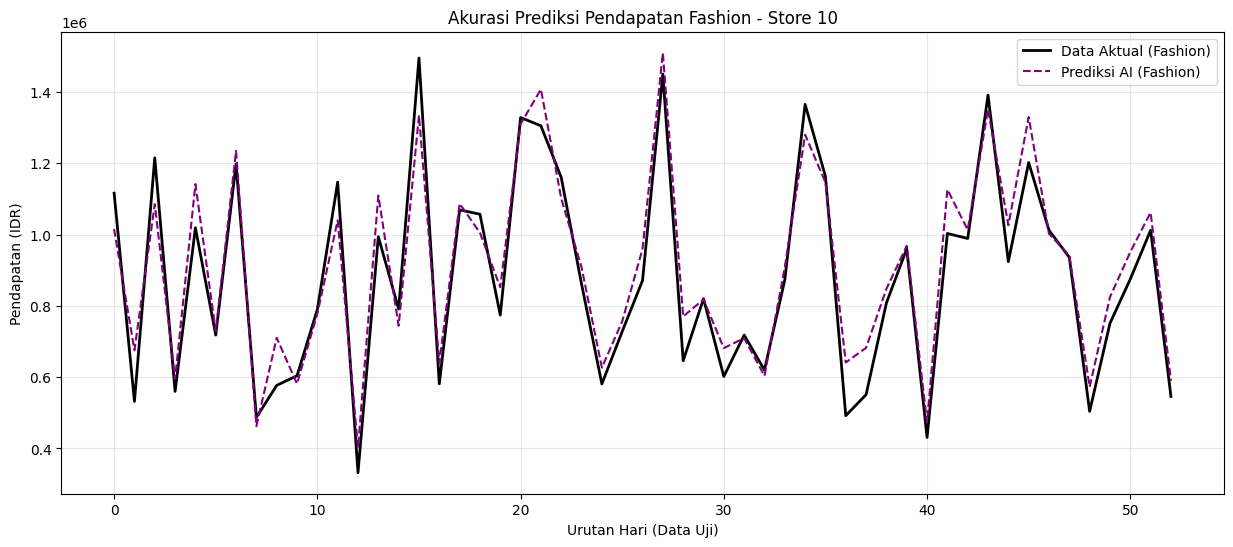

In [32]:
# 5. Visualisasi Prediksi vs Aktual
plt.figure(figsize=(15, 6))
plt.plot(y_actual, label='Data Aktual (Fashion)', color='black', linewidth=2)
plt.plot(y_pred, label='Prediksi AI (Fashion)', color='purple', linestyle='--')
plt.title('Akurasi Prediksi Pendapatan Fashion - Store 10')
plt.ylabel('Pendapatan (IDR)')
plt.xlabel('Urutan Hari (Data Uji)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

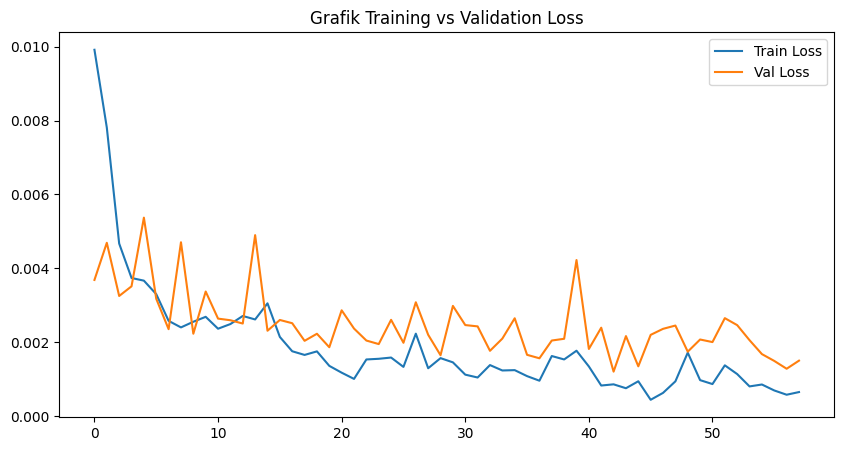

In [33]:
# 6. Visualisasi Training Loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Grafik Training vs Validation Loss')
plt.legend()
plt.show()

# Save Model

In [34]:
# Simpan Model & Scaler Fashion
model_path = '/content/drive/MyDrive/Magang Prima PTKI/models/fashion/model_fashion_store_10.keras'
os.makedirs(os.path.dirname(model_path), exist_ok=True)
best_model.save(model_path)
joblib.dump(scaler_X, '/content/drive/MyDrive/Magang Prima PTKI/models/fashion/scaler_X_fashion.pkl')
joblib.dump(scaler_y, '/content/drive/MyDrive/Magang Prima PTKI/models/fashion/scaler_y_fashion.pkl')

['/content/drive/MyDrive/Magang Prima PTKI/models/fashion/scaler_y_fashion.pkl']

# Kode Inference Dengan Analisis Bisnis

In [35]:
# 1. Load Model & Scaler
model = load_model('/content/drive/MyDrive/Magang Prima PTKI/models/fashion/model_fashion_store_10.keras')
scaler_X = joblib.load('/content/drive/MyDrive/Magang Prima PTKI/models/fashion/scaler_X_fashion.pkl')
scaler_y = joblib.load('/content/drive/MyDrive/Magang Prima PTKI/models/fashion/scaler_y_fashion.pkl')

In [36]:
def get_forecast_7_days_stabilized_fashion(model, df_historical, scaler_X, scaler_y):
    # Ambil data 7 hari terakhir
    current_lags = df_historical['revenue_clean'].tail(7).tolist()

    # Hitung rata-rata per hari dalam seminggu (Stabilizer pola mingguan)
    weekly_pattern = df_historical.groupby(df_historical.index.dayofweek)['revenue_clean'].mean()

    predictions = []
    dates = []
    last_date = df_historical.index[-1]
    id_holidays = holidays.Indonesia(years=[last_date.year, last_date.year + 1])

    print("="*60)
    print(f"   PREDIKSI OPERASIONAL FASHION TERSTABILISASI (7 HARI)")
    print(f"   (Batas Data: {last_date.strftime('%d %b %Y')})")
    print("="*60)

    for i in range(1, 8):
        current_date = last_date + timedelta(days=i)
        day_idx = current_date.weekday()

        # Fitur Engineering
        is_holiday = 1 if current_date.strftime('%Y-%m-%d') in id_holidays else 0
        is_payday = 1 if current_date.day >= 25 or current_date.day <= 5 else 0
        is_weekend = 1 if day_idx >= 5 else 0
        rolling_avg = np.mean(current_lags)
        day_of_month = current_date.day

        # Susun fitur (12 fitur)
        input_row = current_lags + [is_holiday, is_payday, is_weekend, rolling_avg, day_of_month]

        # Scaling & Prediksi
        input_scaled = scaler_X.transform([input_row])
        input_final = input_scaled.reshape((1, 1, len(features)))
        pred_scaled = model.predict(input_final, verbose=0)
        raw_pred = scaler_y.inverse_transform(pred_scaled)[0][0]

        # --- LOGIKA "REM" (STABILIZER) ---
        avg_hist_day = weekly_pattern[day_idx]
        stabilized_pred = (raw_pred * 0.7) + (avg_hist_day * 0.3)

        # Clipping: Mencegah prediksi melompat melebihi batas wajar
        max_limit = df_historical['revenue_clean'].max() * 1.2
        final_pred = min(stabilized_pred, max_limit)

        predictions.append(final_pred)
        dates.append(current_date)

        # Update Lags untuk iterasi berikutnya
        current_lags.pop(0)
        current_lags.append(final_pred)

        # Status berdasarkan statistik deskriptif data fashion
        status = "RAMAI" if final_pred > stats['mean'] * 1.1 else "NORMAL"
        print(f"{current_date.strftime('%A, %d %b')}: Rp {final_pred:,.0f} | {status}")

    return pd.DataFrame({'date': dates, 'pred_revenue': predictions}).set_index('date')

In [37]:
# Jalankan Proyeksi Baru untuk Fashion
forecast_results_fashion = get_forecast_7_days_stabilized_fashion(best_model, time_series_fashion, scaler_X, scaler_y)

   PREDIKSI OPERASIONAL FASHION TERSTABILISASI (7 HARI)
   (Batas Data: 12 Jan 2026)
Tuesday, 13 Jan: Rp 644,944 | NORMAL


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Wednesday, 14 Jan: Rp 611,963 | NORMAL


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Thursday, 15 Jan: Rp 650,564 | NORMAL


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Friday, 16 Jan: Rp 960,787 | NORMAL


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Saturday, 17 Jan: Rp 872,042 | NORMAL


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Sunday, 18 Jan: Rp 834,490 | NORMAL
Monday, 19 Jan: Rp 786,148 | NORMAL


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


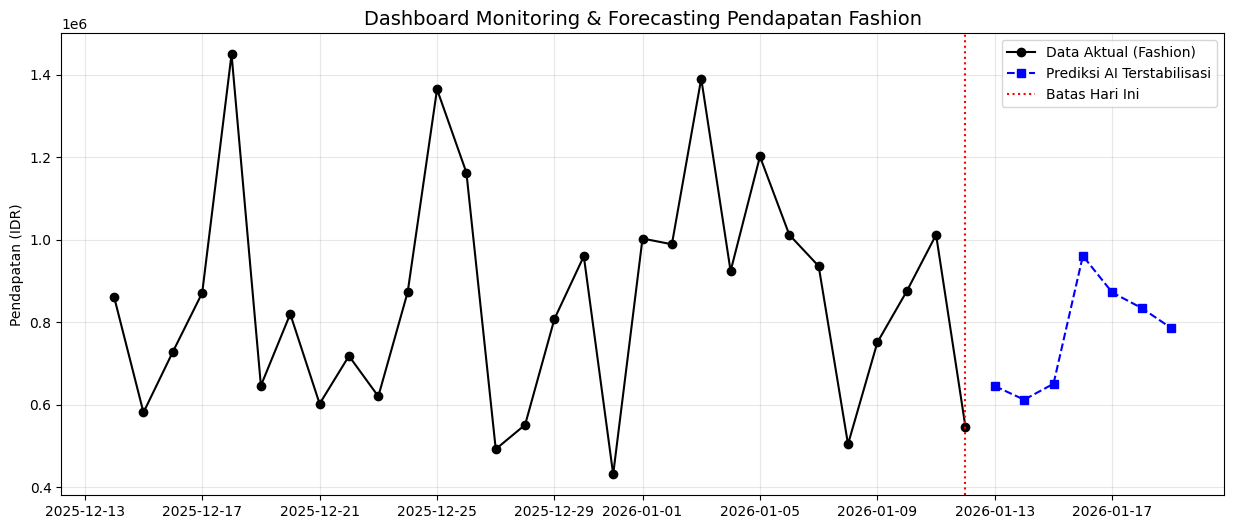

In [38]:
# Visualisasi Dashboard Fashion
plt.figure(figsize=(15, 6))
hist_data_fashion = time_series_fashion.tail(30)

plt.plot(hist_data_fashion.index, hist_data_fashion['revenue_clean'],
         label='Data Aktual (Fashion)', color='black', marker='o')

plt.plot(forecast_results_fashion.index, forecast_results_fashion['pred_revenue'],
         label='Prediksi AI Terstabilisasi', color='blue', linestyle='--', marker='s')

plt.axvline(x=hist_data_fashion.index[-1], color='red', linestyle=':', label='Batas Hari Ini')
plt.title('Dashboard Monitoring & Forecasting Pendapatan Fashion', fontsize=14)
plt.ylabel('Pendapatan (IDR)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()